# 1 Dataset and Task
 (a) Select your choice of neural networks model that is suitable for this task and motivate it. Train your model
 to predict one step ahead data point, during training (see following Figure). Scale your data before training
 and scale them back to be able to compare your predictions with real measurements.
 
 (b) How many past time steps should you input into your network to achieve the best possible performance?
 (Hint: This is a tunable parameter and needs to be tuned).
 
 (c) Once your model is trained, use it to predict the next 200 data points recursively. This means feeding each
 prediction back into the model to generate the subsequent predictions.)
 
 (d) On May 9th, download the real test dataset and evaluate your model by reporting both the Mean Absolute
 Error (MAE) and Mean Squared Error (MSE) between its predictions and the actual test values. Additionally,
 create a plot comparing the predicted and real values to visually assess your models performance.

First, we load the data and take a look at it. We also install torch:

Data shape: (1000, 1)
Data type: uint8
Min value: 2
Max value: 255


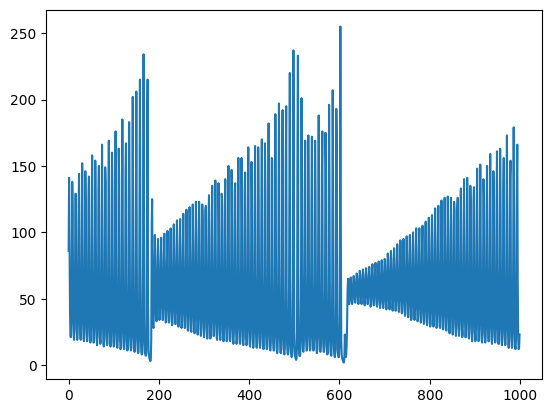

Data shape: (200, 1)
Data type: uint8
Min value: 3
Max value: 255


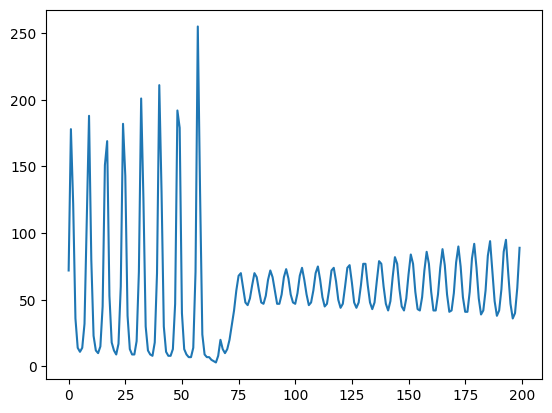

In [1]:
file = 'Xtrain.mat'
# load training data
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

# Load the training data
data = scipy.io.loadmat(file)
X_train = data['Xtrain']

# Display basic information about the data
print(f"Data shape: {X_train.shape}")
print(f"Data type: {X_train.dtype}")
print(f"Min value: {np.min(X_train)}")
print(f"Max value: {np.max(X_train)}")

# plot the data
plt.plot(X_train)
plt.show()

file = 'Xtest.mat'
# load training data
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

# Load the training data
data = scipy.io.loadmat(file)
test_data = data['Xtest']

# Display basic information about the data
print(f"Data shape: {test_data.shape}")
print(f"Data type: {test_data.dtype}")
print(f"Min value: {np.min(test_data)}")
print(f"Max value: {np.max(test_data)}")

# plot the data
plt.plot(test_data)
plt.show()

Now, we scale the data, because then the network works better and faster. 
I also want to scale it back, so that it can get the right outputs.

In [2]:
import sklearn
from sklearn.preprocessing import StandardScaler

#let's scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X_train.reshape(-1, 1))

#We also want the scaled back data ready:
restored_data = scaler.inverse_transform(scaled_data)

# Printing the first few values of the scaled and restored data to check
print(f"First few scaled values:\n{scaled_data[:5]}")
print(f"First few restored values:\n{restored_data[:5]}")

#Display basic information about the data
print(f"Data shape: {scaled_data.shape}")
print(f"Data type: {scaled_data.dtype}")
print(f"Min value: {np.min(scaled_data)}")
print(f"Max value: {np.max(scaled_data)}")

First few scaled values:
[[ 0.55720154]
 [ 1.73111118]
 [ 0.74929585]
 [-0.40326998]
 [-0.8088024 ]]
First few restored values:
[[ 86.]
 [141.]
 [ 95.]
 [ 41.]
 [ 22.]]
Data shape: (1000, 1)
Data type: float64
Min value: -1.2356786270219065
Max value: 4.16430570013708


In [22]:
#making the LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        # Adjust the input size of the linear layer to account for bidirectional LSTM (hidden_size * 2)
        self.fc = nn.Linear(hidden_size * 2, 1)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # use output from last time step
        out = self.dropout(out)
        out = self.fc(out)
        return out

In [23]:
from torch.utils.data import TensorDataset, DataLoader
#Now we want to create sequences from our data, then split into training and validation sets
seq_len = 700

#Define the function that retrieves the sequences:
def create_sequences(data, seq_len):
    sequences = []
    labels = []
    for i in range(len(data) - seq_len):
        seq = data[i:i+seq_len]
        label = data[i+seq_len]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# Define the split ratio for validation data
train_ratio = 0.9
val_ratio = 0.1

# Create sequences from scaled data
X_sequences, y_labels = create_sequences(scaled_data, seq_len)

# Convert to PyTorch tensors
X_sequences = torch.tensor(X_sequences, dtype=torch.float32)
y_labels = torch.tensor(y_labels, dtype=torch.float32)

# Create a TensorDataset
dataset = TensorDataset(X_sequences, y_labels)

# Calculate sizes for train and validation
dataset_size = len(dataset)
train_size = int(train_ratio * dataset_size)
val_size = dataset_size - train_size

# Split the dataset for train and validation
train_dataset, val_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

# Create DataLoaders for training and validation
batch_size = 512
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Print information about the splits
print(f"Total sequences: {dataset_size}")
print(f"Training sequences: {train_size}")
print(f"Validation sequences: {val_size}")


Total sequences: 300
Training sequences: 270
Validation sequences: 30


In [68]:
seq_len

700

/Users/alexamirejibi/miniconda3/envs/laser/lib/python3.13/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Epoch 1/1000 - Train Loss: 0.6884 - Val Loss: 0.7708 (Best Model Saved)
Epoch 11/1000 - Train Loss: 0.6823 - Val Loss: 0.7611 (Best Model Saved)
Epoch 21/1000 - Train Loss: 0.6786 - Val Loss: 0.7518 (Best Model Saved)
Epoch 31/1000 - Train Loss: 0.6743 - Val Loss: 0.7430 (Best Model Saved)
Epoch 41/1000 - Train Loss: 0.6695 - Val Loss: 0.7346 (Best Model Saved)
Epoch 51/1000 - Train Loss: 0.6660 - Val Loss: 0.7268 (Best Model Saved)
Epoch 61/1000 - Train Loss: 0.6590 - Val Loss: 0.7192 (Best Model Saved)
Epoch 71/1000 - Train Loss: 0.6565 - Val Loss: 0.7119 (Best Model Saved)
Epoch 81/1000 - Train Loss: 0.6515 - Val Loss: 0.7048 (Best Model Saved)
Epoch 91/1000 - Train Loss: 0.6497 - Val Loss: 0.6978 (Best Model Saved)
Epoch 101/1000 - Train Loss: 0.6430 - Val Loss: 0.6908 (Best Model Saved)
Epoch 111/1000 - Train Loss: 0.6394 - Val Loss: 0.6837 (Best Model Saved)
Epoch 121/1000 - Train Loss: 0.6334 - Val Loss: 0.6764 (Best Model Saved)
Epoch 131/1000 - Train Loss: 0.6252 - Val Loss: 0

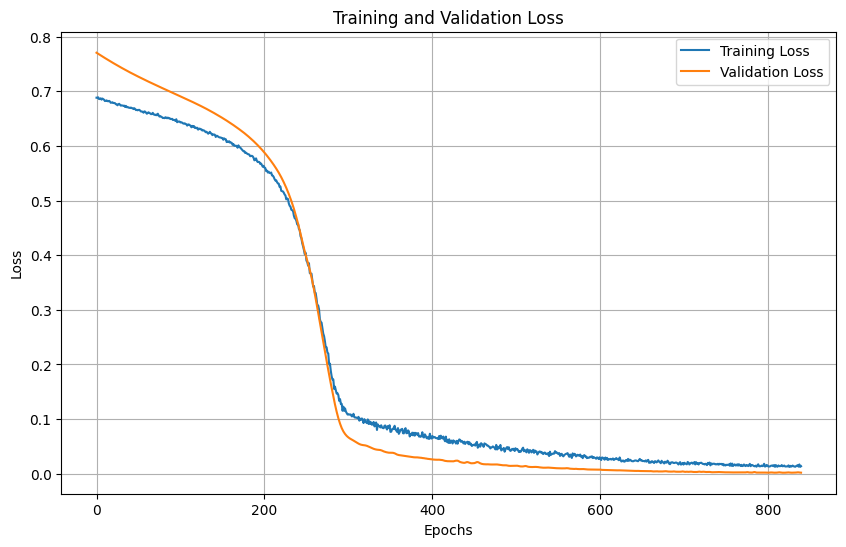

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps')
model = LSTMModel(hidden_size=64, num_layers=1, dropout=0.1).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# training loop with early stopping
num_epochs = 1000
train_losses, val_losses = [], []
best_val_loss = float('inf')
best_model_state = None
best_epoch = -1
patience = 20  # number of epochs to wait for improvement
counter = 0  # counter for patience

for epoch in range(num_epochs):
    # train
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output.squeeze(), y_batch.squeeze())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    # validation loop
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output = model(X_batch)
            loss = criterion(output.squeeze(), y_batch.squeeze())
            val_loss += loss.item()
    
    # record losses
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # save the best model and check for early stopping
    if val_loss < best_val_loss:
        best_epoch = epoch
        best_val_loss = val_loss
        best_model_state = model.state_dict().copy()
        counter = 0  # reset counter
        if epoch % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f} (Best Model Saved)")
    else:
        counter += 1  # increment counter
        if epoch % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")
        
    # early stopping check
    if counter >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs")
        break

# load best model
model.load_state_dict(best_model_state)
print(f"Best validation loss: {best_val_loss:.4f} for epoch {best_epoch}")

## plot losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()



In [26]:



# %%
# autoregressive prediction on the test set
model.eval()
predictions = []
initial_sequence_np = scaled_data[len(scaled_data)-seq_len:].reshape(1, seq_len, 1)
initial_sequence_np.shape

(1, 700, 1)

Test MAE: 48.4880
Test MSE: 3900.8647


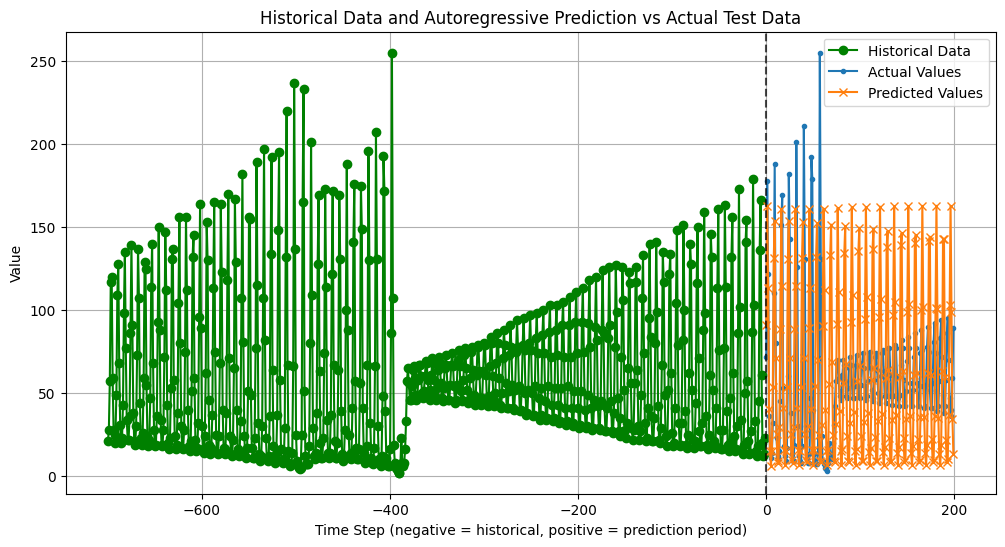

In [27]:
# Get the last seq_len values from the training data
initial_sequence_np = scaled_data[-seq_len:].reshape(1, seq_len, 1)
current_sequence = torch.tensor(initial_sequence_np, dtype=torch.float32).to(device)

num_predictions = len(test_data)

with torch.no_grad():
    for _ in range(num_predictions):
        prediction = model(current_sequence)
        predictions.append(prediction.item())
        # append the prediction and remove the oldest point
        new_point = prediction.reshape(1, 1, 1)
        current_sequence = torch.cat((current_sequence[:, 1:, :], new_point), dim=1)

# inverse transform predictions and actual test data
predicted_values = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
actual_values = test_data

# Get the last portion of training data to show before predictions
history_data = scaler.inverse_transform(scaled_data[-seq_len:].reshape(-1, 1))

# calculate mae and mse
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Make sure both arrays have the same length
min_length = min(len(actual_values), len(predicted_values))
actual_values = actual_values[:min_length]
predicted_values = predicted_values[:min_length]

mae = mean_absolute_error(actual_values, predicted_values)
mse = mean_squared_error(actual_values, predicted_values)

print(f"Test MAE: {mae:.4f}")
print(f"Test MSE: {mse:.4f}")

# plot predictions vs actual with history data
plt.figure(figsize=(12, 6))

# Create time indices for proper alignment
history_indices = np.arange(-len(history_data), 0)
prediction_indices = np.arange(len(predicted_values))

# Plot the historical data before predictions
plt.plot(history_indices, history_data, label='Historical Data', color='green', marker='o')

# Plot the actual and predicted values
plt.plot(prediction_indices, actual_values, label='Actual Values', marker='.')
plt.plot(prediction_indices, predicted_values, label='Predicted Values', marker='x')

# Add a vertical line to separate history from predictions
plt.axvline(x=0, color='black', linestyle='--', alpha=0.7)

plt.title('Historical Data and Autoregressive Prediction vs Actual Test Data')
plt.xlabel('Time Step (negative = historical, positive = prediction period)')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()
